In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import warnings
from pathlib import Path
from v1dd_public import ARTIFACT_DIR
from scipy import stats
from v1dd_public.utils import *
from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import LocallySparseNoise
import statsmodels.stats.multicomp as multi
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from collections import defaultdict
from scipy.stats import ks_2samp

np.random.seed(42) # set seed for reproducibility

In [3]:
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=13
figure_path = Path('/home/naomi/Desktop/figures/v1dd_plots')

In [4]:
# H5_DIR = Path(f"{ARTIFACT_DIR}/lsn_ns_metrics_240627.h5")
# f_events = h5py.File(H5_DIR,'r')
# chase_h5_dir = Path(f"{ARTIFACT_DIR}/stimulus_analyses_v2.h5")

In [5]:
mouse_id = 'M427836'
col_vol_str = '23'
plane_name = f"Plane_1"
plane = 2 # there is a mismatch in plane numbers in h5 and client (0-6 vs. 1-5)

# f_events[mouse_id][col_vol_str].keys()

In [6]:
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
assert DATA_DIR.exists()
DATA_DIR.resolve()

client = OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
print(f'Loaded session {session.get_session_id()}, mouse {session.get_mouse_id()}, column {session.get_column_id()}, volume {session.get_volume_id()}')

lsn = LocallySparseNoise(session, plane, trace_type='events')
dff_traces = session.get_traces(plane, trace_type='dff')
valid_dff_traces = dff_traces[lsn.is_roi_valid, :].values
event_traces = session.get_traces(plane, trace_type='events')
valid_event_traces = event_traces[lsn.is_roi_valid, :].values

print(f'Loaded dff and event traces for {valid_dff_traces.shape[0]} valid ROIs')

Loaded session M427836_23, mouse 427836, column 2, volume 3
Loaded dff and event traces for 542 valid ROIs


In [7]:
# parameters
sample_rate_hz = 6
cond_duration = 1
time_before = -1
time_after = 2
time_after_margin = 1
t_plot = int((cond_duration + time_after + time_before) * sample_rate_hz)
n_trials = 1705
n_cells = valid_dff_traces.shape[0]

dff_trials = np.zeros((n_cells, t_plot, n_trials))
for trial in range(n_trials):
    trial_start = lsn.stim_table.start[trial] + time_before
    trial_end = lsn.stim_table.end[trial] + time_after
    time_mask = (dff_traces.time > trial_start) & (dff_traces.time < trial_end)
    trial_dff = valid_dff_traces[:, time_mask]
    dff_trials[:, :, trial] = trial_dff[:, :t_plot]

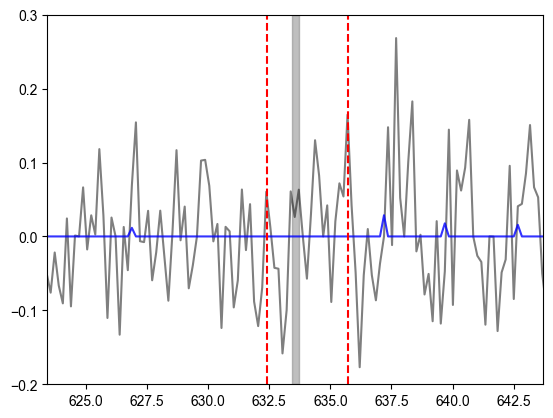

In [8]:
plt.plot(dff_traces.time, valid_dff_traces[3, :], 'k', alpha=0.5, label='dff')
plt.plot(event_traces.time, valid_event_traces[3, :], 'b', alpha=0.8, label='events')

plt.xlim(lsn.stim_table.start[0] - 10, lsn.stim_table.end[0] + 10)
plt.axvspan(xmin=lsn.stim_table.start[0], xmax=lsn.stim_table.end[0], color='gray', alpha=0.5, label='stimulus')
plt.ylim(-0.2, 0.3)
plt.axvline(x=lsn.stim_table.start[0] + time_before, color='r', linestyle='--', label='trial start + time_before')
plt.axvline(x=lsn.stim_table.end[0] + time_after, color='r', linestyle='--', label='trial end + time_after')

In [9]:
s1, s2 = 8, 14
response_thresh_alpha = 0.05
nstd = 3
onset_delay = -1
offset_delay = 2
sample_spontaneous = 1000
if session is None:
    raise ValueError('Session not found')

all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = calc_lsn_p_vals_for_col_vol_plane(session,
                                    plane,
                                    sample_spontaneous,
                                    onset_delay,
                                    offset_delay)

design_matrix, trial_template, frame_images = get_plane_lsn_constants(session)

In [10]:
all_x = []
all_y = []
all_depths = []
all_planes = []
all_columns = []
all_volumes = []
all2p3ps = []

lsn = LocallySparseNoise(session, plane, trace_type = "events")

# get the x and y coordinates of the ROI mask from the image 
for icell in range(lsn.n_rois_valid):
    roi_mask = session.get_roi_image_mask(plane, icell)
    y1, x1 = np.mean(np.where(roi_mask), axis=1, dtype=int)
    depth = session.get_plane_depth(plane)
    all_x.append(x1)
    all_y.append(y1)
    all_depths.append(depth)
    all_planes.append(plane)
    all_columns.append(session.column_id)
    all_volumes.append(session.volume_id)
    all2p3ps.append(int(session.scope_type[0]))

all_x = np.array(all_x)
all_y = np.array(all_y)    
all_depths = np.array(all_depths)
all_planes = np.array(all_planes)
all_columns = np.array(all_columns)
all_volumes = np.array(all_volumes)
all2p3ps = np.array(all2p3ps)

rf_metrics = {
    "mouse_id": mouse_id,
    "column": session.column_id,            
    "volume": session.volume_id,
    "col_vol": col_vol_str,
    "plane": plane,
    "data": {}
}

if lsn.n_rois_valid > 1:
    n_valid_cells_in_colvol_plane = lsn.n_rois_valid
    n_trials = all_pvals_in_colvol_plane.shape[0]
    
    # initialization
    
    valid_cell_index = np.zeros(n_valid_cells_in_colvol_plane, dtype = int) 
    on_center_x = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_y = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_h = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_x = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_y = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_h = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_wx = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_wy = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_wx = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_wy = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_area = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_area = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_averaged_response_at_receptive_field = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_averaged_response_at_receptive_field = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    percentage_res_trial_4_locally_sparse_noise = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    frac_res_trial_4_locally_sparse_noise = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    frac_res_to_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    frac_res_to_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)

    number_of_pixels = int(design_matrix.shape[0]/2) # 112
    number_of_tot_pixels = int(design_matrix.shape[0]/2)*2 # 224
    total_on_off_trials = design_matrix.dot(np.ones(n_trials))
    
    lsn_values = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    p_values = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    is_trial_sig = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    total_responsive_trials_all_pixels = np.zeros(n_valid_cells_in_colvol_plane)
    n_responsive_trials = np.zeros((n_valid_cells_in_colvol_plane, number_of_tot_pixels), dtype = int)
    weighted_avg = np.zeros((n_valid_cells_in_colvol_plane, number_of_tot_pixels))
    weighted_avg_only_resp_trials = np.zeros((n_valid_cells_in_colvol_plane, number_of_tot_pixels))
    is_responsive = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_mean_std = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_chi2 = np.zeros(n_valid_cells_in_colvol_plane)
    chi2_mat_thresholded = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))

    n_responsive_trials_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2), dtype = int)
    weighted_avg_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    weighted_avg_only_resp_trials_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    max_n_responsive_trials_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = int)
    is_responsive_to_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_mean_std_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    z_score_mat_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    has_rf_zscore_on = np.zeros(n_valid_cells_in_colvol_plane)
    sig_on_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    max_wavg_on_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))    
    has_on_rf = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)

    n_responsive_trials_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2), dtype = int)
    weighted_avg_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    weighted_avg_only_resp_trials_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    max_n_responsive_trials_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = int)
    is_responsive_to_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_mean_std_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    z_score_mat_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    has_rf_zscore_off = np.zeros(n_valid_cells_in_colvol_plane)
    sig_off_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    max_wavg_off_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    has_off_rf = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)

    chi2_mat = chi_square_RFs(all_lsn_vals_in_colvol_plane, trial_template)
    mu_spont = np.mean(all_lsn_vals_in_colvol_plane, 0)
    max_spont = np.max(all_lsn_vals_in_colvol_plane, 0)
    min_spont = np.min(all_lsn_vals_in_colvol_plane, 0)


In [11]:
cell = 336
valid_cell_index[cell] = cell
lsn_values[cell, :] = all_lsn_vals_in_colvol_plane[:, cell] 
p_values[cell, :] = all_pvals_in_colvol_plane[:, cell]
is_trial_sig[cell, :] = all_pvals_in_colvol_plane[:, cell] < response_thresh_alpha
total_responsive_trials_all_pixels[cell] = is_trial_sig[cell, :].sum() 

n_responsive_trials[cell, :] = design_matrix.dot(is_trial_sig[cell, :]) # just average
percentage_res_trial_4_locally_sparse_noise[cell] = total_responsive_trials_all_pixels[cell]*100/is_trial_sig.shape[1]
frac_res_trial_4_locally_sparse_noise[cell] = total_responsive_trials_all_pixels[cell]/is_trial_sig.shape[1]
weighted_avg[cell, :] = design_matrix.dot(all_lsn_vals_in_colvol_plane[:, cell]) # weighted average (based on responsiveness score)
only_resp_trials_design_matrix = design_matrix[:, is_trial_sig[cell, :].astype(bool)]
lsn_vals_only_resp_trials = all_lsn_vals_in_colvol_plane[is_trial_sig[cell, :].astype(bool), cell]
weighted_avg_only_resp_trials[cell, :] = only_resp_trials_design_matrix.dot(lsn_vals_only_resp_trials) # weighted average only based on responsive trials (based on responsiveness score)

is_responsive[cell] = is_cell_responsive(n_responsive_trials[cell, :], weighted_avg[cell, :], min_responsive_trials = 8, nstd = 3)
has_rf_mean_std[cell] = cell_has_rf(weighted_avg[cell, :], nstd = nstd)
chi2_mat_thresholded[cell, :, :] = chi2_mat[cell, :, :] < 0.05

has_rf_chi2[cell] = chi2_mat_thresholded[cell, :, :].sum().astype(bool)

print(f'Cell {cell} is responsive: {is_responsive[cell]}')

Cell 336 is responsive: True


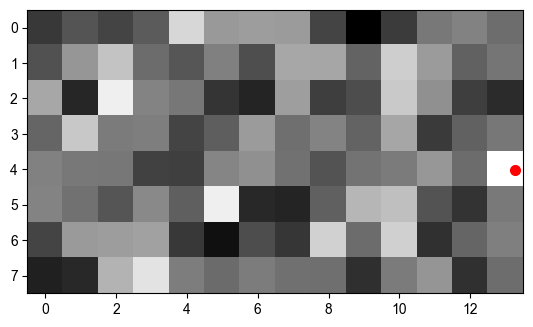

In [12]:
n_responsive_trials_on[cell, :, :] = n_responsive_trials[cell, :number_of_pixels].reshape(s1, s2)
total_on_trials = total_on_off_trials[:number_of_pixels].reshape(s1, s2)
frac_res_to_on[cell] = (n_responsive_trials_on[cell, :, :] / total_on_trials).max()

on_frame_idxs = np.multiply(design_matrix[n_responsive_trials_on[cell, :, :].argmax()], is_trial_sig[cell, :].T).nonzero()[0]
sig_on_frames[cell, on_frame_idxs] = 1

on_wavg_frame_idxs = np.multiply(design_matrix[weighted_avg_on[cell, :, :].argmax()], is_trial_sig[cell, :].T).nonzero()[0]
max_wavg_on_frames[cell, on_wavg_frame_idxs] = 1

weighted_avg_on[cell, :, :] = weighted_avg[cell, :number_of_pixels].reshape(s1, s2)
weighted_avg_only_resp_trials_on[cell, :, :] = weighted_avg_only_resp_trials[cell, :number_of_pixels].reshape(s1, s2)
max_n_responsive_trials_on[cell] = n_responsive_trials_on[cell, :].max()
is_responsive_to_on[cell] = is_cell_responsive(n_responsive_trials_on[cell, :], weighted_avg_on[cell, :], min_responsive_trials = 8, nstd = 3)
has_rf_mean_std_on [cell] = cell_has_rf(weighted_avg_on[cell, :], nstd = nstd)
z_score_mat_on[cell, :, :], has_rf_zscore_on[cell] = rf_z_test(weighted_avg_on[cell, :])
on_averaged_response_at_receptive_field[cell] = weighted_avg_on[cell, :, :].max()

gauss_input = z_score_mat_on[cell, :, :]
gauss_input_argmax = np.where(gauss_input == gauss_input.max())
h_initial = gauss_input.max()
x_initial = gauss_input_argmax[0]
y_initial = gauss_input_argmax[1]
on_params = centroid(gauss_input,
                initial_weight=[x_initial,y_initial,h_initial,1,1])

plt.imshow(gauss_input, cmap='binary_r')
plt.plot(on_params[1], on_params[0], 'ro', markersize=7)

Cell 336 is responsive: True


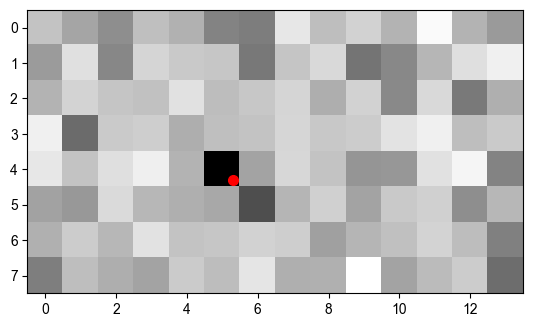

In [13]:
n_responsive_trials_off[cell, :, :] = n_responsive_trials[cell, number_of_pixels:].reshape(s1, s2)
total_off_trials = total_on_off_trials[number_of_pixels:].reshape(s1, s2)
frac_res_to_off[cell] = (n_responsive_trials_off[cell, :, :] / total_off_trials).max()

off_frame_idxs = np.multiply(design_matrix[n_responsive_trials_off[cell, :, :].argmax()+112], is_trial_sig[cell, :].T).nonzero()[0]
sig_off_frames [cell, off_frame_idxs] = 1

off_wavg_frame_idxs = np.multiply(design_matrix[weighted_avg_on[cell, :, :].argmax()+112], is_trial_sig[cell, :].T).nonzero()[0]
max_wavg_off_frames[cell, off_wavg_frame_idxs] = 1        

weighted_avg_off[cell, :, :] = weighted_avg[cell, number_of_pixels:].reshape(s1, s2)
weighted_avg_only_resp_trials_off[cell, :, :] = weighted_avg_only_resp_trials[cell, number_of_pixels:].reshape(s1, s2)  
max_n_responsive_trials_off [cell] = n_responsive_trials_off[cell, :].max()
is_responsive_to_off[cell] = is_cell_responsive(n_responsive_trials_off[cell, :], weighted_avg_off[cell, :], min_responsive_trials = 8, nstd = 3)
has_rf_mean_std_off[cell] = cell_has_rf(weighted_avg_off[cell, :], nstd = nstd)
z_score_mat_off[cell, :, :], has_rf_zscore_off[cell] = rf_z_test(weighted_avg_off[cell, :])

off_averaged_response_at_receptive_field[cell] = weighted_avg_off[cell, :, :].max()

gauss_input = z_score_mat_off[cell, :, :]
gauss_input_argmax = np.where(gauss_input == gauss_input.max())
h_initial = gauss_input.max()
x_initial = gauss_input_argmax[0]
y_initial = gauss_input_argmax[1]
off_params = centroid(gauss_input,
                initial_weight=[x_initial,y_initial,h_initial,1,1])
off_center_x[cell] = off_params[1]
off_center_y[cell] = off_params[0]
off_center_h[cell] = off_params[2]
off_center_wx[cell] = off_params[4]*4
off_center_wy[cell] = off_params[3]*4
off_area[cell] = off_center_wx[cell] * off_center_wy[cell] * off_center_h[cell]
has_off_rf [cell] = (off_center_wx[cell] < 5) and (off_center_wy[cell] < 5) and h_initial > 2.5 

plt.imshow(gauss_input, cmap='binary')
plt.plot(off_params[1], off_params[0], 'ro', markersize=7)

print(f'Cell {cell} is responsive: {is_responsive[cell]}')

In [14]:
H5_DIR = Path(f"{ARTIFACT_DIR}/lsn_ns_metrics_240627.h5")
f_events = h5py.File(H5_DIR,'r')
chase_h5_dir = Path(f"{ARTIFACT_DIR}/stimulus_analyses_v2.h5")

In [15]:
cell = 205

plane_info_events = f_events[mouse_id][col_vol_str][plane_name]
n_responsive_trials_on_events = plane_info_events['n_responsive_trials_on']
n_responsive_trials_off_events = plane_info_events['n_responsive_trials_off']
responsiveness_score_on_events = plane_info_events['max_n_responsive_trials_on']
responsiveness_score_off_events = plane_info_events['max_n_responsive_trials_off']
p_values_events = plane_info_events['p_values']
sig_on_frames_events = plane_info_events['sig_on_frames']
sig_off_frames_events = plane_info_events['sig_off_frames']
max_wavg_on_frames_events = plane_info_events['max_wavg_on_frames']
max_wavg_off_frames_events = plane_info_events['max_wavg_off_frames']
lsn_values_events = plane_info_events['lsn_values']
mu_spont_events = plane_info_events['mu_spont']
max_spont_events = plane_info_events['max_spont']
min_spont_events = plane_info_events['min_spont']
weighted_avg_on_events = plane_info_events['weighted_avg_on']
weighted_avg_off_events = plane_info_events['weighted_avg_off']
z_score_mat_on_events = plane_info_events['z_score_mat_on']
z_score_mat_off_events = plane_info_events['z_score_mat_off']
is_responsive_events = plane_info_events['is_responsive']
is_responsive_to_on_events = plane_info_events['is_responsive_to_on']
is_responsive_to_off_events = plane_info_events['is_responsive_to_off']
has_on_rf = plane_info_events['has_rf_v2_on']
has_off_rf = plane_info_events['has_rf_v2_off']

n_cells = z_score_mat_on_events.shape[0]
z_score_mat_on_thresholded_events = np.zeros((n_cells, 8, 14))

for icell in range(n_cells):
    z_score_mat_on_thresholded_events[icell, :, :] = z_score_mat_on_events[icell, :, :] > 2.5

n_cells = z_score_mat_off_events.shape[0]
z_score_mat_off_thresholded_events = np.zeros((n_cells, 8, 14))
z_score_mat_off_thresholded_dff = np.zeros((n_cells, 8, 14))

for icell in range(n_cells):
    z_score_mat_off_thresholded_events[icell, :, :] = z_score_mat_off_events[icell, :, :] > 2.5
    
data = z_score_mat_on_events[cell, :, :]
data1 = data > 2.5
x_initial, y_initial, gauss_input_on = find_rf_center_v2(n_responsive_trials_on_events[cell, :], weighted_avg_on_events[cell, :])
h_initial = gauss_input_on.max()
rf_center = np.zeros_like(gauss_input_on)
rf_center[x_initial, y_initial] = data1[x_initial, y_initial]
has_rf = has_on_rf[cell]
print(f'Cell has an ON RF: {has_rf}')

data = z_score_mat_off_events[cell, :, :]
data1 = data > 2.5
x_initial, y_initial, gauss_input_off = find_rf_center_v2(n_responsive_trials_off_events[cell, :], weighted_avg_off_events[cell, :])
h_initial = gauss_input_off.max()
rf_center = np.zeros_like(gauss_input_off)
rf_center[x_initial, y_initial] = data1[x_initial, y_initial]
has_rf = has_off_rf[cell]
print(f'Cell has an OFF RF: {has_rf}')

Cell has an ON RF: True
Cell has an OFF RF: True


Text(0.5, 1.0, 'Subfield shape')

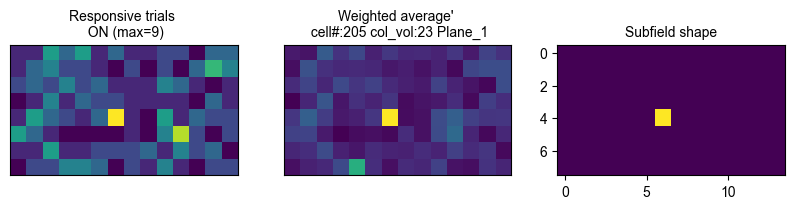

In [16]:
fig = plt.figure(figsize = (10, 5))
font_size = 10

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(n_responsive_trials_on_events[cell, :, :])
ax1.set_title(f'Responsive trials \n ON (max={n_responsive_trials_on_events[cell, :, :].max()})', fontsize = 10)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(weighted_avg_on_events[cell, :, :])
ax2.set_title(f"Weighted average' \n cell#:{cell} col_vol:{col_vol_str} {plane_name}" , fontsize = font_size)
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(gauss_input_on)
ax3.set_title('Subfield shape', fontsize = font_size)
# ax3.set_xticks([])
# ax3.set_yticks([])

Text(0.5, 1.0, 'Subfield shape')

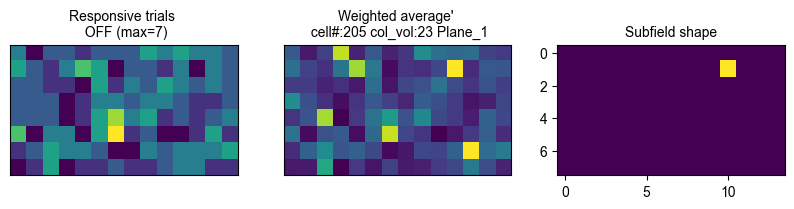

In [17]:
fig = plt.figure(figsize = (10, 5))
font_size = 10

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(n_responsive_trials_off_events[cell, :, :])
ax1.set_title(f'Responsive trials \n OFF (max={n_responsive_trials_off_events[cell, :, :].max()})', fontsize = 10)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(weighted_avg_off_events[cell, :, :])
ax2.set_title(f"Weighted average' \n cell#:{cell} col_vol:{col_vol_str} {plane_name}" , fontsize = font_size)
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(gauss_input_off)
ax3.set_title('Subfield shape', fontsize = font_size)
# ax3.set_xticks([])
# ax3.set_yticks([])

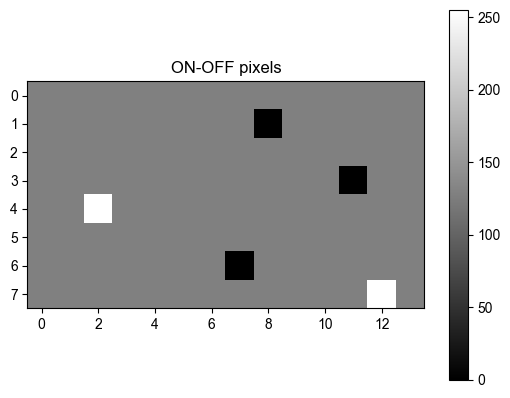

In [18]:
on_pixels = design_matrix[:, 0][:112].reshape(8, 14)
on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)
off_pixels = design_matrix[:, 0][112:].reshape(8, 14)
off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)

# plt.figure()
# plt.imshow(on_pixels, cmap='grey', vmin=0, vmax=255)
# plt.title('ON pixels')
# plt.colorbar()

# plt.figure()
# plt.imshow(off_pixels, cmap='grey', vmin=0, vmax=255)
# plt.title('OFF pixels')
# plt.colorbar()

on_pixels_mod = np.select([on_pixels == 255, on_pixels == 255/2], [1, 0], on_pixels)
off_pixels_mod = np.select([off_pixels == 0, off_pixels == 255/2], [-1, 0], off_pixels)
on_off_pixels = on_pixels_mod + off_pixels_mod
on_off_pixels = np.select([on_off_pixels == 1, on_off_pixels == -1, on_off_pixels == 0], [255, 0, 255/2], on_off_pixels)
plt.figure()
plt.imshow(on_off_pixels, cmap='gray', vmin=0, vmax=255)
plt.title('ON-OFF pixels')
plt.colorbar()


In [19]:
on_trials = []
off_trials = []
other_trials = []

for i in range(1705):
    trial = design_matrix[:, i]
    on_trial = trial[:112].reshape(8, 14)
    off_trial = trial[112:].reshape(8, 14)

    off_subfield = np.where(gauss_input_off == True)
    for j in range(np.shape(off_subfield)[1]):
        if off_trial[off_subfield[0][j], off_subfield[1][j]] == 1:
            off_trials.append(i)
    
    on_subfield = np.where(gauss_input_on == True)
    for j in range(np.shape(on_subfield)[1]):
        if on_trial[on_subfield[0][j], on_subfield[1][j]] == 1:
            on_trials.append(i)
    
    other_subfield = ([0], [13])
    for j in range(np.shape(other_subfield)[1]):
        if off_trial[other_subfield[0][j], other_subfield[1][j]] == 1:
            other_trials.append(i)

on_trials = np.array(on_trials)
off_trials = np.array(off_trials)
other_trials = np.array(other_trials)

on_trials.shape, off_trials.shape, other_trials.shape

((44,), (44,), (44,))

In [20]:
on_subfield

(array([4]), array([6]))

In [21]:
on_pixels = design_matrix[:, trial][:112].reshape(8, 14)
on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)
off_pixels = design_matrix[:, trial][112:].reshape(8, 14)
off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)

# plt.figure()
# plt.imshow(on_pixels, cmap='grey', vmin=0, vmax=255)
# plt.title('ON pixels')
# plt.colorbar()

# plt.figure()
# plt.imshow(off_pixels, cmap='grey', vmin=0, vmax=255)
# plt.title('OFF pixels')
# plt.colorbar()

on_pixels_mod = np.select([on_pixels == 255, on_pixels == 255/2], [1, 0], on_pixels)
off_pixels_mod = np.select([off_pixels == 0, off_pixels == 255/2], [-1, 0], off_pixels)
on_off_pixels = on_pixels_mod + off_pixels_mod
on_off_pixels = np.select([on_off_pixels == 1, on_off_pixels == -1, on_off_pixels == 0], [255, 0, 255/2], on_off_pixels)
plt.figure()
plt.imshow(on_off_pixels, cmap='gray', vmin=0, vmax=255)
plt.title('ON-OFF pixels')
plt.colorbar()


ValueError: cannot reshape array of size 25088 into shape (8,14)

In [22]:
all_trials = np.zeros((len(off_trials), 8, 14))
dff_trials_subset = np.zeros((len(off_trials), t_plot))
events_subset = np.zeros((len(off_trials), t_plot))

for idx, trial_num in enumerate(on_trials):
    trial = design_matrix[:, trial_num]
    on_pixels = trial[:112].reshape(8, 14)
    on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)
    off_pixels = trial[112:].reshape(8, 14)
    off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)
    
    on_pixels_mod = np.select([on_pixels == 255, on_pixels == 255/2], [1, 0], on_pixels)
    off_pixels_mod = np.select([off_pixels == 0, off_pixels == 255/2], [-1, 0], off_pixels)
    on_off_pixels = on_pixels_mod + off_pixels_mod
    on_off_pixels = np.select([on_off_pixels == 1, on_off_pixels == -1, on_off_pixels == 0], [255, 0, 255/2], on_off_pixels)

    all_trials[idx, :, :] = on_off_pixels

    trial_start = lsn.stim_table.start[trial_num] + time_before
    trial_end = lsn.stim_table.end[trial_num] + time_after
    time_mask = (dff_traces.time > trial_start) & (dff_traces.time < trial_end)
    trial_dff = valid_dff_traces[:, time_mask]
    dff_trials_subset[idx, :] = trial_dff[cell, :t_plot]

    trial_start = lsn.stim_table.start[trial_num] + time_before
    trial_end = lsn.stim_table.end[trial_num] + time_after
    time_mask = (event_traces.time > trial_start) & (event_traces.time < trial_end)
    trial_events = valid_event_traces[:, time_mask]
    events_subset[idx, :] = trial_events[cell, :t_plot]

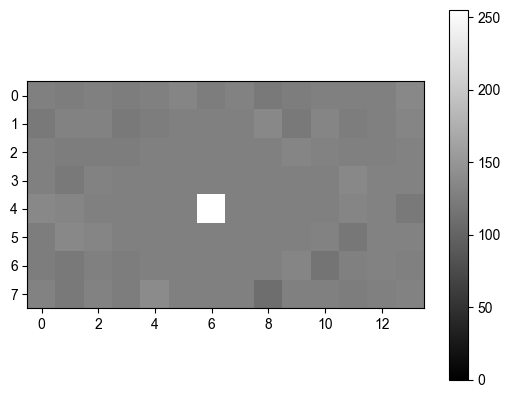

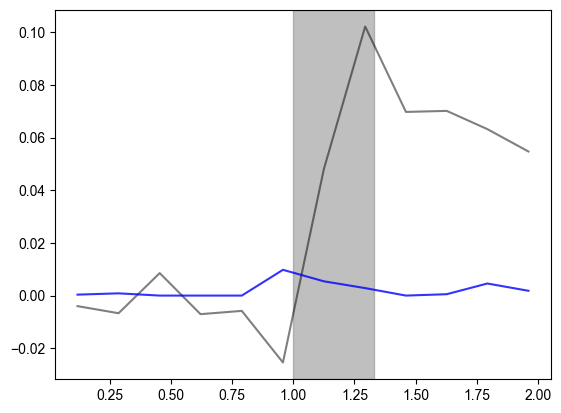

In [23]:
plt.imshow(np.mean(all_trials, axis=0), cmap='gray', vmin=0, vmax=255)
plt.colorbar()

plt.figure()
plt.plot(dff_traces.time[:t_plot], dff_trials_subset.mean(axis=0), 'k', alpha=0.5, label='dff')
plt.plot(event_traces.time[:t_plot], events_subset.mean(axis=0), 'b', alpha=0.8, label='events')

plt.axvspan(xmin=-time_before, xmax=-time_before+0.33, color='gray', alpha=0.5, label='stimulus')

## Redoing the analysis and checking the ON/OFF RFs

In [24]:
s1, s2 = 8, 14
response_thresh_alpha = 0.05
nstd = 3
onset_delay = -1
offset_delay = 2
sample_spontaneous = 1000
if session is None:
    raise ValueError('Session not found')

all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = calc_lsn_p_vals_for_col_vol_plane(session,
                                    plane,
                                    sample_spontaneous,
                                    onset_delay,
                                    offset_delay)

design_matrix, trial_template, frame_images = get_plane_lsn_constants(session)

all_x = []
all_y = []
all_depths = []
all_planes = []
all_columns = []
all_volumes = []
all2p3ps = []

lsn = LocallySparseNoise(session, plane, trace_type = "events")

# get the x and y coordinates of the ROI mask from the image 
for icell in range(lsn.n_rois_valid):
    roi_mask = session.get_roi_image_mask(plane, icell)
    y1, x1 = np.mean(np.where(roi_mask), axis=1, dtype=int)
    depth = session.get_plane_depth(plane)
    all_x.append(x1)
    all_y.append(y1)
    all_depths.append(depth)
    all_planes.append(plane)
    all_columns.append(session.column_id)
    all_volumes.append(session.volume_id)
    all2p3ps.append(int(session.scope_type[0]))

all_x = np.array(all_x)
all_y = np.array(all_y)    
all_depths = np.array(all_depths)
all_planes = np.array(all_planes)
all_columns = np.array(all_columns)
all_volumes = np.array(all_volumes)
all2p3ps = np.array(all2p3ps)

rf_metrics = {
    "mouse_id": mouse_id,
    "column": session.column_id,            
    "volume": session.volume_id,
    "col_vol": col_vol_str,
    "plane": plane,
    "data": {}
}

if lsn.n_rois_valid > 1:
    n_valid_cells_in_colvol_plane = lsn.n_rois_valid
    n_trials = all_pvals_in_colvol_plane.shape[0]
    
    # initialization
    
    valid_cell_index = np.zeros(n_valid_cells_in_colvol_plane, dtype = int) 
    on_center_x = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_y = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_h = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_x = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_y = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_h = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_wx = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_wy = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_wx = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_wy = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_area = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_area = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_averaged_response_at_receptive_field = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_averaged_response_at_receptive_field = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    percentage_res_trial_4_locally_sparse_noise = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    frac_res_trial_4_locally_sparse_noise = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    frac_res_to_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    frac_res_to_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)

    number_of_pixels = int(design_matrix.shape[0]/2) # 112
    number_of_tot_pixels = int(design_matrix.shape[0]/2)*2 # 224
    total_on_off_trials = design_matrix.dot(np.ones(n_trials))
    
    lsn_values = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    p_values = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    is_trial_sig = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    total_responsive_trials_all_pixels = np.zeros(n_valid_cells_in_colvol_plane)
    n_responsive_trials = np.zeros((n_valid_cells_in_colvol_plane, number_of_tot_pixels), dtype = int)
    weighted_avg = np.zeros((n_valid_cells_in_colvol_plane, number_of_tot_pixels))
    weighted_avg_only_resp_trials = np.zeros((n_valid_cells_in_colvol_plane, number_of_tot_pixels))
    is_responsive = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_mean_std = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_chi2 = np.zeros(n_valid_cells_in_colvol_plane)
    chi2_mat_thresholded = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))

    n_responsive_trials_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2), dtype = int)
    weighted_avg_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    weighted_avg_only_resp_trials_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    max_n_responsive_trials_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = int)
    is_responsive_to_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_mean_std_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    z_score_mat_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    has_rf_zscore_on = np.zeros(n_valid_cells_in_colvol_plane)
    sig_on_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    max_wavg_on_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))    
    has_on_rf = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)

    n_responsive_trials_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2), dtype = int)
    weighted_avg_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    weighted_avg_only_resp_trials_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    max_n_responsive_trials_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = int)
    is_responsive_to_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_mean_std_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    z_score_mat_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    has_rf_zscore_off = np.zeros(n_valid_cells_in_colvol_plane)
    sig_off_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    max_wavg_off_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    has_off_rf = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)

    chi2_mat = chi_square_RFs(all_lsn_vals_in_colvol_plane, trial_template)
    mu_spont = np.mean(all_lsn_vals_in_colvol_plane, 0)
    max_spont = np.max(all_lsn_vals_in_colvol_plane, 0)
    min_spont = np.min(all_lsn_vals_in_colvol_plane, 0)

In [25]:
valid_cell_index[cell] = cell
lsn_values[cell, :] = all_lsn_vals_in_colvol_plane[:, cell] 
p_values[cell, :] = all_pvals_in_colvol_plane[:, cell]
is_trial_sig[cell, :] = all_pvals_in_colvol_plane[:, cell] < response_thresh_alpha
total_responsive_trials_all_pixels[cell] = is_trial_sig[cell, :].sum() 

n_responsive_trials[cell, :] = design_matrix.dot(is_trial_sig[cell, :]) # just average
percentage_res_trial_4_locally_sparse_noise[cell] = total_responsive_trials_all_pixels[cell]*100/is_trial_sig.shape[1]
frac_res_trial_4_locally_sparse_noise[cell] = total_responsive_trials_all_pixels[cell]/is_trial_sig.shape[1]
weighted_avg[cell, :] = design_matrix.dot(all_lsn_vals_in_colvol_plane[:, cell]) # weighted average (based on responsiveness score)
only_resp_trials_design_matrix = design_matrix[:, is_trial_sig[cell, :].astype(bool)]
lsn_vals_only_resp_trials = all_lsn_vals_in_colvol_plane[is_trial_sig[cell, :].astype(bool), cell]
weighted_avg_only_resp_trials[cell, :] = only_resp_trials_design_matrix.dot(lsn_vals_only_resp_trials) # weighted average only based on responsive trials (based on responsiveness score)

is_responsive[cell] = is_cell_responsive(n_responsive_trials[cell, :], weighted_avg[cell, :], min_responsive_trials = 8, nstd = 3)
has_rf_mean_std[cell] = cell_has_rf(weighted_avg[cell, :], nstd = nstd)
chi2_mat_thresholded[cell, :, :] = chi2_mat[cell, :, :] < 0.05

has_rf_chi2[cell] = chi2_mat_thresholded[cell, :, :].sum().astype(bool)

n_responsive_trials_on[cell, :, :] = n_responsive_trials[cell, :number_of_pixels].reshape(s1, s2)
total_on_trials = total_on_off_trials[:number_of_pixels].reshape(s1, s2)
frac_res_to_on[cell] = (n_responsive_trials_on[cell, :, :] / total_on_trials).max()

on_frame_idxs = np.multiply(design_matrix[n_responsive_trials_on[cell, :, :].argmax()], is_trial_sig[cell, :].T).nonzero()[0]
sig_on_frames[cell, on_frame_idxs] = 1

on_wavg_frame_idxs = np.multiply(design_matrix[weighted_avg_on[cell, :, :].argmax()], is_trial_sig[cell, :].T).nonzero()[0]
max_wavg_on_frames[cell, on_wavg_frame_idxs] = 1

weighted_avg_on[cell, :, :] = weighted_avg[cell, :number_of_pixels].reshape(s1, s2)
weighted_avg_only_resp_trials_on[cell, :, :] = weighted_avg_only_resp_trials[cell, :number_of_pixels].reshape(s1, s2)
max_n_responsive_trials_on[cell] = n_responsive_trials_on[cell, :].max()
is_responsive_to_on[cell] = is_cell_responsive(n_responsive_trials_on[cell, :], weighted_avg_on[cell, :], min_responsive_trials = 8, nstd = 3)
has_rf_mean_std_on [cell] = cell_has_rf(weighted_avg_on[cell, :], nstd = nstd)
z_score_mat_on[cell, :, :], has_rf_zscore_on[cell] = rf_z_test(weighted_avg_on[cell, :])
on_averaged_response_at_receptive_field[cell] = weighted_avg_on[cell, :, :].max()

gauss_input = z_score_mat_on[cell, :, :]
gauss_input_argmax = np.where(gauss_input == gauss_input.max())
h_initial = gauss_input.max()
x_initial = gauss_input_argmax[0]
y_initial = gauss_input_argmax[1]
on_params = centroid(gauss_input,
                initial_weight=[x_initial,y_initial,h_initial,1,1])

on_center_x[cell] = on_params[1]
on_center_y[cell] = on_params[0]
on_center_h[cell] = on_params[2]
on_center_wx[cell] = on_params[4]*4
on_center_wy[cell] = on_params[3]*4
on_area[cell] = on_center_wx[cell] * on_center_wy[cell] * on_center_h[cell]
has_on_rf [cell] = (on_center_wx[cell] < 5) and (on_center_wy[cell] < 5) and h_initial > 2.5

n_responsive_trials_off[cell, :, :] = n_responsive_trials[cell, number_of_pixels:].reshape(s1, s2)
total_off_trials = total_on_off_trials[number_of_pixels:].reshape(s1, s2)
frac_res_to_off[cell] = (n_responsive_trials_off[cell, :, :] / total_off_trials).max()

off_frame_idxs = np.multiply(design_matrix[n_responsive_trials_off[cell, :, :].argmax()+112], is_trial_sig[cell, :].T).nonzero()[0]
sig_off_frames [cell, off_frame_idxs] = 1

off_wavg_frame_idxs = np.multiply(design_matrix[weighted_avg_on[cell, :, :].argmax()+112], is_trial_sig[cell, :].T).nonzero()[0]
max_wavg_off_frames[cell, off_wavg_frame_idxs] = 1        

weighted_avg_off[cell, :, :] = weighted_avg[cell, number_of_pixels:].reshape(s1, s2)
weighted_avg_only_resp_trials_off[cell, :, :] = weighted_avg_only_resp_trials[cell, number_of_pixels:].reshape(s1, s2)  
max_n_responsive_trials_off [cell] = n_responsive_trials_off[cell, :].max()
is_responsive_to_off[cell] = is_cell_responsive(n_responsive_trials_off[cell, :], weighted_avg_off[cell, :], min_responsive_trials = 8, nstd = 3)
has_rf_mean_std_off[cell] = cell_has_rf(weighted_avg_off[cell, :], nstd = nstd)
z_score_mat_off[cell, :, :], has_rf_zscore_off[cell] = rf_z_test(weighted_avg_off[cell, :])

off_averaged_response_at_receptive_field[cell] = weighted_avg_off[cell, :, :].max()

gauss_input = z_score_mat_off[cell, :, :]
gauss_input_argmax = np.where(gauss_input == gauss_input.max())
h_initial = gauss_input.max()
x_initial = gauss_input_argmax[0]
y_initial = gauss_input_argmax[1]
off_params = centroid(gauss_input,
                initial_weight=[x_initial,y_initial,h_initial,1,1])
off_center_x[cell] = off_params[1]
off_center_y[cell] = off_params[0]
off_center_h[cell] = off_params[2]
off_center_wx[cell] = off_params[4]*4
off_center_wy[cell] = off_params[3]*4
off_area[cell] = off_center_wx[cell] * off_center_wy[cell] * off_center_h[cell]
has_off_rf [cell] = (off_center_wx[cell] < 5) and (off_center_wy[cell] < 5) and h_initial > 2.5

print('Results with old (?) method')
print(f'Cell has an ON RF: {has_on_rf[cell]}')
print(f'\tCenter: ({on_center_x[cell]}, {on_center_y[cell]})')
print(f'Cell has an OFF RF: {has_off_rf[cell]}')
print(f'\tCenter: ({off_center_x[cell]}, {off_center_y[cell]})')

Results with old (?) method
Cell has an ON RF: True
	Center: (5.999980926513672, 3.999983787536621)
Cell has an OFF RF: True
	Center: (9.999940872192383, 0.9061380624771118)


In [26]:
s1, s2 = 8, 14
response_thresh_alpha = 0.05
nstd = 3
onset_delay = -1
offset_delay = 2
sample_spontaneous = 1000
if session is None:
    raise ValueError('Session not found')

all_lsn_vals_in_colvol_plane, all_pvals_in_colvol_plane, cell_indices  = calc_lsn_p_vals_for_col_vol_plane(session,
                                    plane,
                                    sample_spontaneous,
                                    onset_delay,
                                    offset_delay)

design_matrix, trial_template, frame_images = get_plane_lsn_constants(session)

all_x = []
all_y = []
all_depths = []
all_planes = []
all_columns = []
all_volumes = []
all2p3ps = []

lsn = LocallySparseNoise(session, plane, trace_type = "events")

# get the x and y coordinates of the ROI mask from the image 
for icell in range(lsn.n_rois_valid):
    roi_mask = session.get_roi_image_mask(plane, icell)
    y1, x1 = np.mean(np.where(roi_mask), axis=1, dtype=int)
    depth = session.get_plane_depth(plane)
    all_x.append(x1)
    all_y.append(y1)
    all_depths.append(depth)
    all_planes.append(plane)
    all_columns.append(session.column_id)
    all_volumes.append(session.volume_id)
    all2p3ps.append(int(session.scope_type[0]))

all_x = np.array(all_x)
all_y = np.array(all_y)    
all_depths = np.array(all_depths)
all_planes = np.array(all_planes)
all_columns = np.array(all_columns)
all_volumes = np.array(all_volumes)
all2p3ps = np.array(all2p3ps)

rf_metrics = {
    "mouse_id": mouse_id,
    "column": session.column_id,            
    "volume": session.volume_id,
    "col_vol": col_vol_str,
    "plane": plane,
    "data": {}
}

if lsn.n_rois_valid > 1:
    n_valid_cells_in_colvol_plane = lsn.n_rois_valid
    n_trials = all_pvals_in_colvol_plane.shape[0]
    
    # initialization
    
    valid_cell_index = np.zeros(n_valid_cells_in_colvol_plane, dtype = int) 
    on_center_x = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_y = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_h = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_x = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_y = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_h = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_wx = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_center_wy = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_wx = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_center_wy = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_area = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_area = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    on_averaged_response_at_receptive_field = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    off_averaged_response_at_receptive_field = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    percentage_res_trial_4_locally_sparse_noise = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    frac_res_trial_4_locally_sparse_noise = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    frac_res_to_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)
    frac_res_to_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = float)

    number_of_pixels = int(design_matrix.shape[0]/2) # 112
    number_of_tot_pixels = int(design_matrix.shape[0]/2)*2 # 224
    total_on_off_trials = design_matrix.dot(np.ones(n_trials))
    
    lsn_values = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    p_values = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    is_trial_sig = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    total_responsive_trials_all_pixels = np.zeros(n_valid_cells_in_colvol_plane)
    n_responsive_trials = np.zeros((n_valid_cells_in_colvol_plane, number_of_tot_pixels), dtype = int)
    weighted_avg = np.zeros((n_valid_cells_in_colvol_plane, number_of_tot_pixels))
    weighted_avg_only_resp_trials = np.zeros((n_valid_cells_in_colvol_plane, number_of_tot_pixels))
    is_responsive = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_mean_std = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_chi2 = np.zeros(n_valid_cells_in_colvol_plane)
    chi2_mat_thresholded = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))

    n_responsive_trials_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2), dtype = int)
    weighted_avg_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    weighted_avg_only_resp_trials_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    max_n_responsive_trials_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = int)
    is_responsive_to_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_mean_std_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_v2_on = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    z_score_mat_on = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    has_rf_zscore_on = np.zeros(n_valid_cells_in_colvol_plane)
    sig_on_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    max_wavg_on_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))    
    has_on_rf = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)

    n_responsive_trials_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2), dtype = int)
    weighted_avg_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    weighted_avg_only_resp_trials_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    max_n_responsive_trials_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = int)
    is_responsive_to_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_mean_std_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    has_rf_v2_off = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)
    z_score_mat_off = np.zeros((n_valid_cells_in_colvol_plane, s1, s2))
    has_rf_zscore_off = np.zeros(n_valid_cells_in_colvol_plane)
    sig_off_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    max_wavg_off_frames = np.zeros((n_valid_cells_in_colvol_plane, n_trials))
    has_off_rf = np.zeros(n_valid_cells_in_colvol_plane, dtype = bool)

    chi2_mat = chi_square_RFs(all_lsn_vals_in_colvol_plane, trial_template)
    mu_spont = np.mean(all_lsn_vals_in_colvol_plane, 0)
    max_spont = np.max(all_lsn_vals_in_colvol_plane, 0)
    min_spont = np.min(all_lsn_vals_in_colvol_plane, 0)

    # initialization
    valid_cell_index = np.zeros(n_valid_cells_in_colvol_plane, dtype=int)
    on_center_x_orig = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_center_y_orig = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_center_x_orig = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_center_y_orig = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_center_x = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_center_y = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_center_h = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_angle = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_center_x = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_center_y = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_center_h = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_angle = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_angle_degree = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_angle_degree = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_center_wx = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_center_wy = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_center_wx = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_center_wy = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_area = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    off_area = np.zeros(n_valid_cells_in_colvol_plane, dtype=float)
    on_averaged_response_at_receptive_field = np.zeros(
        n_valid_cells_in_colvol_plane, dtype=float
    )
    off_averaged_response_at_receptive_field = np.zeros(
        n_valid_cells_in_colvol_plane, dtype=float
    )

    gauss_w_coeff = 7

In [27]:
# rf metrics
valid_cell_index[cell] = cell

lsn_values[cell, :] = all_lsn_vals_in_colvol_plane[:, cell]
p_values[cell, :] = all_pvals_in_colvol_plane[:, cell]
is_trial_sig[cell, :] = (
    all_pvals_in_colvol_plane[:, cell] < response_thresh_alpha
)

total_responsive_trials_all_pixels[cell] = is_trial_sig[cell, :].sum()

n_responsive_trials[cell, :] = design_matrix.dot(
    is_trial_sig[cell, :]
)  # just average
percentage_res_trial_4_locally_sparse_noise[cell] = (
    total_responsive_trials_all_pixels[cell] * 100 / is_trial_sig.shape[1]
)
frac_res_trial_4_locally_sparse_noise[cell] = (
    total_responsive_trials_all_pixels[cell] / is_trial_sig.shape[1]
)

weighted_avg[cell, :] = design_matrix.dot(
    all_lsn_vals_in_colvol_plane[:, cell]
)  # weighted average (based on responsiveness score)

only_resp_trials_design_matrix = design_matrix[
    :, is_trial_sig[cell, :].astype(bool)
]
lsn_vals_only_resp_trials = all_lsn_vals_in_colvol_plane[
    is_trial_sig[cell, :].astype(bool), cell
]
weighted_avg_only_resp_trials[cell, :] = only_resp_trials_design_matrix.dot(
    lsn_vals_only_resp_trials
)  # weighted average only based on responsive trials (based on responsiveness score)

is_responsive[cell] = is_cell_responsive(
    n_responsive_trials[cell, :],
    weighted_avg[cell, :],
    min_responsive_trials=8,
    nstd=3,
)
has_rf_mean_std[cell] = cell_has_rf(weighted_avg[cell, :], nstd=nstd)
chi2_mat_thresholded[cell, :, :] = chi2_mat[cell, :, :] < 0.05

has_rf_chi2[cell] = chi2_mat_thresholded[cell, :, :].sum().astype(bool)

n_responsive_trials_on[cell, :, :] = n_responsive_trials[
    cell, :number_of_pixels
].reshape(s1, s2)
total_on_trials = total_on_off_trials[:number_of_pixels].reshape(s1, s2)
frac_res_to_on[cell] = (
    n_responsive_trials_on[cell, :, :] / total_on_trials
).max()

on_frame_idxs = np.multiply(
    design_matrix[n_responsive_trials_on[cell, :, :].argmax()],
    is_trial_sig[cell, :].T,
).nonzero()[0]
sig_on_frames[cell, on_frame_idxs] = 1

on_wavg_frame_idxs = np.multiply(
    design_matrix[weighted_avg_on[cell, :, :].argmax()],
    is_trial_sig[cell, :].T,
).nonzero()[0]
max_wavg_on_frames[cell, on_wavg_frame_idxs] = 1

weighted_avg_on[cell, :, :] = weighted_avg[cell, :number_of_pixels].reshape(
    s1, s2
)
weighted_avg_only_resp_trials_on[cell, :, :] = (
    weighted_avg_only_resp_trials[cell, :number_of_pixels].reshape(s1, s2)
)
max_n_responsive_trials_on[cell] = n_responsive_trials_on[cell, :].max()
is_responsive_to_on[cell] = is_cell_responsive(
    n_responsive_trials_on[cell, :],
    weighted_avg_on[cell, :],
    min_responsive_trials=8,
    nstd=3,
)
has_rf_mean_std_on[cell] = cell_has_rf(weighted_avg_on[cell, :], nstd=nstd)
has_rf_v2_on[cell] = cell_has_rf_v2(
    n_responsive_trials_on[cell, :],
    weighted_avg_on[cell, :],
    min_responsive_trials=7,
    nstd=3,
)
z_score_mat_on[cell, :, :], has_rf_zscore_on[cell] = rf_z_test(
    weighted_avg_on[cell, :]
)
on_averaged_response_at_receptive_field[cell] = weighted_avg_on[
    cell, :, :
].max()

x_initial, y_initial, gauss_input = find_rf_center_v2(
    n_responsive_trials_on[cell, :], weighted_avg_on[cell, :]
)
on_center_x_orig[cell] = x_initial
on_center_y_orig[cell] = y_initial

h_initial = gauss_input.max()
on_angle_deg = assign_angle(gauss_input, x_initial, y_initial)

on_params = centroid(
    gauss_input, initial_weight=[x_initial, y_initial, h_initial, 1, 1]
)  # center_x, center_y, height, width_x, width_y)

on_center_x[cell] = on_params[1]
on_center_y[cell] = on_params[0]
on_center_h[cell] = on_params[2]
on_center_wx[cell] = on_params[4] * gauss_w_coeff
on_center_wy[cell] = on_params[3] * gauss_w_coeff
on_angle[cell] = -1 * on_params[5]
on_angle_degree[cell] = on_angle_deg
on_area[cell] = np.pi * on_center_wx[cell] * on_center_wy[cell]
has_on_rf[cell] = (
    (on_center_wx[cell] < 5)
    and (on_center_wy[cell] < 5)
    and h_initial > 2.5
)

n_responsive_trials_off[cell, :, :] = n_responsive_trials[
    cell, number_of_pixels:
].reshape(s1, s2)
total_off_trials = total_on_off_trials[number_of_pixels:].reshape(s1, s2)
frac_res_to_off[cell] = (
    n_responsive_trials_off[cell, :, :] / total_off_trials
).max()

off_frame_idxs = np.multiply(
    design_matrix[n_responsive_trials_off[cell, :, :].argmax() + 112],
    is_trial_sig[cell, :].T,
).nonzero()[0]
sig_off_frames[cell, off_frame_idxs] = 1

off_wavg_frame_idxs = np.multiply(
    design_matrix[weighted_avg_on[cell, :, :].argmax() + 112],
    is_trial_sig[cell, :].T,
).nonzero()[0]
max_wavg_off_frames[cell, off_wavg_frame_idxs] = 1

weighted_avg_off[cell, :, :] = weighted_avg[
    cell, number_of_pixels:
].reshape(s1, s2)
weighted_avg_only_resp_trials_off[cell, :, :] = (
    weighted_avg_only_resp_trials[cell, number_of_pixels:].reshape(s1, s2)
)
max_n_responsive_trials_off[cell] = n_responsive_trials_off[cell, :].max()
is_responsive_to_off[cell] = is_cell_responsive(
    n_responsive_trials_off[cell, :],
    weighted_avg_off[cell, :],
    min_responsive_trials=8,
    nstd=3,
)
has_rf_mean_std_off[cell] = cell_has_rf(
    weighted_avg_off[cell, :], nstd=nstd
)
has_rf_v2_off[cell] = cell_has_rf_v2(
    n_responsive_trials_off[cell, :],
    weighted_avg_off[cell, :],
    min_responsive_trials=7,
    nstd=3,
)
z_score_mat_off[cell, :, :], has_rf_zscore_off[cell] = rf_z_test(
    weighted_avg_off[cell, :]
)

off_averaged_response_at_receptive_field[cell] = weighted_avg_off[
    cell, :, :
].max()

x_initial, y_initial, gauss_input = find_rf_center_v2(
    n_responsive_trials_off[cell, :], weighted_avg_off[cell, :]
)
off_center_x_orig[cell] = x_initial
off_center_y_orig[cell] = y_initial

h_initial = gauss_input.max()
off_angle_deg = assign_angle(gauss_input, x_initial, y_initial)

off_params = centroid(
    gauss_input, initial_weight=[x_initial, y_initial, h_initial, 1, 1]
)  # center_x, center_y, height, width_x, width_y)
off_center_x[cell] = off_params[1]
off_center_y[cell] = off_params[0]
off_center_h[cell] = off_params[2]
off_center_wx[cell] = off_params[4] * gauss_w_coeff
off_center_wy[cell] = off_params[3] * gauss_w_coeff
off_angle[cell] = -1 * off_params[5]
off_angle_degree[cell] = off_angle_deg

off_area[cell] = np.pi * off_center_wx[cell] * off_center_wy[cell]
has_on_rf[cell] = (
    (off_center_wx[cell] < 5)
    and (off_center_wy[cell] < 5)
    and h_initial > 2.5
)

print('Results with new method')
print(f'Cell has an ON RF: {has_on_rf[cell]}')
print(f'\tCenter: ({on_center_x[cell]}, {on_center_y[cell]})')
print(f'Cell has an OFF RF: {has_off_rf[cell]}')
print(f'\tCenter: ({off_center_x[cell]}, {off_center_y[cell]})')

Results with new method
Cell has an ON RF: False
	Center: (6.000977516174316, 3.9985692501068115)
Cell has an OFF RF: False
	Center: (10.0, 1.0)


In [28]:
for cell in range(542):
    # rf metrics
    valid_cell_index[cell] = cell

    lsn_values[cell, :] = all_lsn_vals_in_colvol_plane[:, cell]
    p_values[cell, :] = all_pvals_in_colvol_plane[:, cell]
    is_trial_sig[cell, :] = (
        all_pvals_in_colvol_plane[:, cell] < (response_thresh_alpha)
    )

    total_responsive_trials_all_pixels[cell] = is_trial_sig[cell, :].sum()

    n_responsive_trials[cell, :] = design_matrix.dot(
        is_trial_sig[cell, :]
    )  # just average
    percentage_res_trial_4_locally_sparse_noise[cell] = (
        total_responsive_trials_all_pixels[cell] * 100 / is_trial_sig.shape[1]
    )
    frac_res_trial_4_locally_sparse_noise[cell] = (
        total_responsive_trials_all_pixels[cell] / is_trial_sig.shape[1]
    )

    weighted_avg[cell, :] = design_matrix.dot(
        all_lsn_vals_in_colvol_plane[:, cell]
    )  # weighted average (based on responsiveness score)

    only_resp_trials_design_matrix = design_matrix[
        :, is_trial_sig[cell, :].astype(bool)
    ]
    lsn_vals_only_resp_trials = all_lsn_vals_in_colvol_plane[
        is_trial_sig[cell, :].astype(bool), cell
    ]
    weighted_avg_only_resp_trials[cell, :] = only_resp_trials_design_matrix.dot(
        lsn_vals_only_resp_trials
    )  # weighted average only based on responsive trials (based on responsiveness score)

    is_responsive[cell] = is_cell_responsive(
        n_responsive_trials[cell, :],
        weighted_avg[cell, :],
        min_responsive_trials=8,
        nstd=3,
    )
    has_rf_mean_std[cell] = cell_has_rf(weighted_avg[cell, :], nstd=nstd)
    chi2_mat_thresholded[cell, :, :] = chi2_mat[cell, :, :] < 0.05

    has_rf_chi2[cell] = chi2_mat_thresholded[cell, :, :].sum().astype(bool)

    n_responsive_trials_on[cell, :, :] = n_responsive_trials[
        cell, :number_of_pixels
    ].reshape(s1, s2)
    total_on_trials = total_on_off_trials[:number_of_pixels].reshape(s1, s2)
    frac_res_to_on[cell] = (
        n_responsive_trials_on[cell, :, :] / total_on_trials
    ).max()

    on_frame_idxs = np.multiply(
        design_matrix[n_responsive_trials_on[cell, :, :].argmax()],
        is_trial_sig[cell, :].T,
    ).nonzero()[0]
    sig_on_frames[cell, on_frame_idxs] = 1

    on_wavg_frame_idxs = np.multiply(
        design_matrix[weighted_avg_on[cell, :, :].argmax()],
        is_trial_sig[cell, :].T,
    ).nonzero()[0]
    max_wavg_on_frames[cell, on_wavg_frame_idxs] = 1

    weighted_avg_on[cell, :, :] = weighted_avg[cell, :number_of_pixels].reshape(
        s1, s2
    )
    weighted_avg_only_resp_trials_on[cell, :, :] = (
        weighted_avg_only_resp_trials[cell, :number_of_pixels].reshape(s1, s2)
    )
    max_n_responsive_trials_on[cell] = n_responsive_trials_on[cell, :].max()
    is_responsive_to_on[cell] = is_cell_responsive(
        n_responsive_trials_on[cell, :],
        weighted_avg_on[cell, :],
        min_responsive_trials=8,
        nstd=3,
    )
    has_rf_mean_std_on[cell] = cell_has_rf(weighted_avg_on[cell, :], nstd=nstd)
    has_rf_v2_on[cell] = cell_has_rf_v2(
        n_responsive_trials_on[cell, :],
        weighted_avg_on[cell, :],
        min_responsive_trials=7,
        nstd=3,
    )
    z_score_mat_on[cell, :, :], has_rf_zscore_on[cell] = rf_z_test(
        weighted_avg_on[cell, :]
    )
    on_averaged_response_at_receptive_field[cell] = weighted_avg_on[
        cell, :, :
    ].max()

    x_initial, y_initial, gauss_input = find_rf_center_v2(
        n_responsive_trials_on[cell, :], weighted_avg_on[cell, :]
    )
    on_center_x_orig[cell] = x_initial
    on_center_y_orig[cell] = y_initial

    h_initial = gauss_input.max()
    on_angle_deg = assign_angle(gauss_input, x_initial, y_initial)

    on_params = centroid(
        gauss_input, initial_weight=[x_initial, y_initial, h_initial, 1, 1]
    )  # center_x, center_y, height, width_x, width_y)

    on_center_x[cell] = on_params[1]
    on_center_y[cell] = on_params[0]
    on_center_h[cell] = on_params[2]
    on_center_wx[cell] = on_params[4] * gauss_w_coeff
    on_center_wy[cell] = on_params[3] * gauss_w_coeff
    on_angle[cell] = -1 * on_params[5]
    on_angle_degree[cell] = on_angle_deg
    on_area[cell] = np.pi * on_center_wx[cell] * on_center_wy[cell]
    has_on_rf[cell] = (
        (on_center_wx[cell] < 5)
        and (on_center_wy[cell] < 5)
        and h_initial > 2.5
    )

    n_responsive_trials_off[cell, :, :] = n_responsive_trials[
        cell, number_of_pixels:
    ].reshape(s1, s2)
    total_off_trials = total_on_off_trials[number_of_pixels:].reshape(s1, s2)
    frac_res_to_off[cell] = (
        n_responsive_trials_off[cell, :, :] / total_off_trials
    ).max()

    off_frame_idxs = np.multiply(
        design_matrix[n_responsive_trials_off[cell, :, :].argmax() + 112],
        is_trial_sig[cell, :].T,
    ).nonzero()[0]
    sig_off_frames[cell, off_frame_idxs] = 1

    off_wavg_frame_idxs = np.multiply(
        design_matrix[weighted_avg_on[cell, :, :].argmax() + 112],
        is_trial_sig[cell, :].T,
    ).nonzero()[0]
    max_wavg_off_frames[cell, off_wavg_frame_idxs] = 1

    weighted_avg_off[cell, :, :] = weighted_avg[
        cell, number_of_pixels:
    ].reshape(s1, s2)
    weighted_avg_only_resp_trials_off[cell, :, :] = (
        weighted_avg_only_resp_trials[cell, number_of_pixels:].reshape(s1, s2)
    )
    max_n_responsive_trials_off[cell] = n_responsive_trials_off[cell, :].max()
    is_responsive_to_off[cell] = is_cell_responsive(
        n_responsive_trials_off[cell, :],
        weighted_avg_off[cell, :],
        min_responsive_trials=8,
        nstd=3,
    )
    has_rf_mean_std_off[cell] = cell_has_rf(
        weighted_avg_off[cell, :], nstd=nstd
    )
    has_rf_v2_off[cell] = cell_has_rf_v2(
        n_responsive_trials_off[cell, :],
        weighted_avg_off[cell, :],
        min_responsive_trials=7,
        nstd=3,
    )
    z_score_mat_off[cell, :, :], has_rf_zscore_off[cell] = rf_z_test(
        weighted_avg_off[cell, :]
    )

    off_averaged_response_at_receptive_field[cell] = weighted_avg_off[
        cell, :, :
    ].max()

    x_initial, y_initial, gauss_input = find_rf_center_v2(
        n_responsive_trials_off[cell, :], weighted_avg_off[cell, :]
    )
    off_center_x_orig[cell] = x_initial
    off_center_y_orig[cell] = y_initial

    h_initial = gauss_input.max()
    off_angle_deg = assign_angle(gauss_input, x_initial, y_initial)

    off_params = centroid(
        gauss_input, initial_weight=[x_initial, y_initial, h_initial, 1, 1]
    )  # center_x, center_y, height, width_x, width_y)
    off_center_x[cell] = off_params[1]
    off_center_y[cell] = off_params[0]
    off_center_h[cell] = off_params[2]
    off_center_wx[cell] = off_params[4] * gauss_w_coeff
    off_center_wy[cell] = off_params[3] * gauss_w_coeff
    off_angle[cell] = -1 * off_params[5]
    off_angle_degree[cell] = off_angle_deg

    off_area[cell] = np.pi * off_center_wx[cell] * off_center_wy[cell]
    has_off_rf[cell] = (
        (off_center_wx[cell] < 5)
        and (off_center_wy[cell] < 5)
        and h_initial > 2.5
    )

    if has_rf_v2_on[cell] and has_rf_v2_off[cell]:
        print(f'Cell {cell} has both an ON and OFF RF')
        # print(f'\tON: ({on_center_x[cell]}, {on_center_y[cell]})')
        # print(f'\tOFF: ({off_center_x[cell]}, {off_center_y[cell]})')
        print(f'\tDistance between ON and OFF: {np.sqrt((on_center_x[cell] - off_center_x[cell])**2 + (on_center_y[cell] - off_center_y[cell])**2)}')
    # print('Results with new method')
    # print(f'Cell has an ON RF: {has_on_rf[cell]}')
    # print(f'\tCenter: ({on_center_x[cell]}, {on_center_y[cell]})')
    # print(f'Cell has an OFF RF: {has_off_rf[cell]}')
    # print(f'\tCenter: ({off_center_x[cell]}, {off_center_y[cell]})')

Cell 6 has both an ON and OFF RF
	Distance between ON and OFF: 3.306995729431125
Cell 7 has both an ON and OFF RF
	Distance between ON and OFF: 4.242320544262291
Cell 10 has both an ON and OFF RF
	Distance between ON and OFF: 4.719961133034924
Cell 11 has both an ON and OFF RF
	Distance between ON and OFF: 3.833595679318097
Cell 21 has both an ON and OFF RF
	Distance between ON and OFF: 1.4060297893272884


KeyboardInterrupt: 

In [ ]:
all_lsn_vals_in_colvol_plane[:, cell].shape

(1705,)

In [ ]:
all_lsn_vals_in_colvol_plane[:, cell]

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [ ]:
### create new function to calculate RFs

# using method as in de Vries et al 2020
"""The receptive field was computed by using an event-triggered average. 
Because more than one stimulus spot was present during a given trial, 
it is not possible to infer the stimulus–response relationship between 
spot locations and responses on a per-trial basis. Therefore, a 
statistically significant co-occurrence of spot presentation and 
responses across trials defined the inclusion criteria for membership 
of a stimulus spot in the receptive field. To begin, the stimulus was 
convolved with a spatial Gaussian (4.65° per sigma), to allow pooling 
of contributions to responses from nearby spots. A P value was 
computed for each spot (black and white separately) by constructing 
a null distribution for the number of trials that a spot was present 
during responsive trials. This per-spot null distribution was 
estimated by shuffling the identity of the responsive trials 
(n = 10,000 shuffles). Statistical outliers were identified by 
computing a P value for each spot relative to its null distribution. 
These P values were corrected for false discoveries by using the 
Šidák multiplecomparisons correction and thresholded at P = 0.05 to 
identify receptive field membership."""

### implementing method for single session
# convolve spatial Gaussian (4.65° per sigma) with stimulus 
# to allow pooling of contributions to responses from nearby spots
lsn = LocallySparseNoise(session, plane, trace_type = "events")
design_matrix = lsn.design_matrix
pixel_to_degree = 9.3 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Define the parameters
sigma = 4.65  # standard deviation in degrees
# size = 100  # size of the grid

# # Create a grid of x and y coordinates
# x = np.linspace(-7, 7, size)
# y = np.linspace(-10, 10, size)
# X, Y = np.meshgrid(x, y)
dx = 9.3 # each pixel is 9.3 degrees 
gx = np.arange(-3*sigma, 3*sigma, 14)
gy = np.arange(-3*sigma, 3*sigma, 14)
X, Y = np.meshgrid(gx, gy)

# gaussian = np.exp(-(x/sigma)**2/2)
# result = np.convolve(original_curve, gaussian, mode="full")
# 
# Calculate the Gaussian function
Z = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
# Z /= np.sum(Z)  # Normalize the kernel

# Generate a random 2D array (or replace with your specific array)
trial = design_matrix[:, trial_num]
on_pixels = trial[:112].reshape(8, 14)
on_pixels = np.select([on_pixels == 1, on_pixels == 0], [255, 255/2], on_pixels)
off_pixels = trial[112:].reshape(8, 14)
off_pixels = np.select([off_pixels == 1, off_pixels == 0], [0, 255/2], off_pixels)

on_pixels_mod = np.select([on_pixels == 255, on_pixels == 255/2], [1, 0], on_pixels)
off_pixels_mod = np.select([off_pixels == 0, off_pixels == 255/2], [-1, 0], off_pixels)
on_off_pixels = on_pixels_mod + off_pixels_mod
on_off_pixels = np.select([on_off_pixels == 1, on_off_pixels == -1, on_off_pixels == 0], [255, 0, 255/2], on_off_pixels)
data = on_off_pixels

# Perform the convolution
convolved_data = convolve2d(data, Z, mode='same', boundary='symm')

# Plot the original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='grey', vmin=0, vmax=255)
plt.title('Original Data')
plt.colorbar()

# Plot the convolved data
plt.subplot(1, 2, 2)
plt.imshow(convolved_data, cmap='grey', vmin=0, vmax=255)
plt.title('Convolved Data with Gaussian Kernel')
plt.colorbar()

plt.show()

NameError: name 'design_matrix' is not defined